In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import os
from PIL import Image

from shutil import copyfile
import base64
from io import BytesIO
from IPython.display import HTML
import pickle
import imutils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Activation
from keras.layers import Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model

from mtcnn.mtcnn import MTCNN
# print version

import cv2
import copy

from tqdm import tqdm
import glob

Using TensorFlow backend.


In [2]:
def print_conf_mat(conf_mat,labels,filename = ""):
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat,cmap = plt.cm.summer)
    for i, row in enumerate(conf_mat):
            for j, c in enumerate(row):
                if c>0:
                    plt.text(j-.2, i+.1, c, fontsize=16)

    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(filename+'.eps')
    plt.show()

In [3]:
class Image():
    
    def __init__(self, image, landmarks, name):
        # self.image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.image = image
        self.original_image = copy.deepcopy(self.image)
        self.landmarks = landmarks
        self.name = name
        self.neutralised_image = np.array([])
        self.hash = hash(self)
    
    def setNeutralisedImage(self, image):
        self.neutralised_image = image
        
    def getNeutralisedImage(self):
        return self.neutralised_image
        
    def getName(self):
        return self.name
        
    def getImage(self):
        return self.image
    
    def clearImage(self):
        self.image= copy.deepcopy(self.original_image)
        return self.image
    
    def getLandmarks(self):
        return self.landmarks
    
    def getHash(self):
        return self.hash

In [4]:
def getLandmarksForImage(imagePath):
    cur_landmark = "\\".join(str(imagePath).rsplit('\\',3)[-3:])[:-4]
    landmark_path = ck_landmarks_path + '\\' + cur_landmark + '_landmarks.txt'
    landmarks = np.loadtxt(landmark_path)
    return landmarks


def view_landmarks(landmarks, color='r'):
    xs, ys = list(zip(*landmarks))
    plt.scatter(xs, ys, color=color)
    return 

In [5]:
base_path = "..\\Data"

In [6]:
ck_data_path = base_path + '\\CK+\\cohn-kanade-images'
ck_landmarks_path = base_path + '\\CK+\\Landmarks'
ck_image_files = glob.glob(ck_data_path+'/**/*.png', recursive=True)

#ck_image_files = ck_image_files[7000:]

In [7]:
len(ck_image_files)

10708

In [8]:
face_det = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt_tree.xml")

def detect_face(f, ld):
    ''' function to detect face, crop the image and resize it and resize the corresponding landmarks too '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
#     ld = np.array([np.array(i) for i in ld])
    crop_ld = ld
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        fw, fh = w, h
        if any(ld[:,0] > x+w):
            fw = int(max(ld[:,0]-x))
        if any(ld[:,1] > y+h):
            fh = int(max(ld[:,1]-y))
#         gray = gray[y:y+h, x:x+w] #Cut the frame to size
        gray = gray[y:y+fh+5, x:x+fw+5] #Cut the frame to size to max of landmark with padding of 5px
        ld_rescale_factor = (gray.shape[1]/crop_imsize, (gray.shape[0]/crop_imsize))
        crop_ld = np.array(list(zip(ld[:,0]-x, ld[:, 1]-y)))
    try:
        output = cv2.resize(gray, (crop_imsize, crop_imsize))
        crop_ld = crop_ld/ld_rescale_factor
        cv2.imwrite(crop_path+'/crop_'+f.split('/')[-1], output)
    except:
        output = gray

    return output, crop_ld

In [9]:
images = []
crop_imsize = 480

with tqdm(total=len(ck_image_files), desc="Processing entries") as pbar:
    for i, ck_image in enumerate(ck_image_files):
        

        landmarks = getLandmarksForImage(ck_image)
        image, landmarks = detect_face(ck_image, landmarks)
        image = cv2.resize(image,(crop_imsize, crop_imsize))
        images.append(Image(image, landmarks, ck_image))
        
        pbar.update(1)

Processing entries: 100%|████████████████████████████████████████████████████████| 10708/10708 [30:59<00:00,  5.76it/s]


In [10]:
numImages = len(images)

avgLandmarks = (images[0].getLandmarks() / numImages)

for image in images[1:]:
    avgLandmarks += (image.getLandmarks()) / numImages

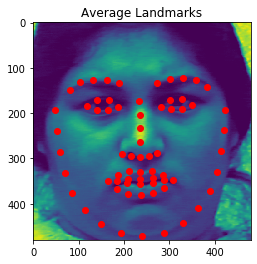

In [11]:
plt.imshow(images[0].getImage())
plt.title("Average Landmarks")
view_landmarks(avgLandmarks)

In [12]:
def appendLastRowAsCol(npMatrix):
    return np.c_[npMatrix[:-1,:].T, np.array([npMatrix[-1,:]]).T ]

In [13]:
def pairPlot(im1, im2, clear_figure=False, title=''):
    if not clear_figure:
        plt.figure()
    
    fig, axes = plt.subplots(1,2)
    axes[0].imshow(im1)
    axes[1].imshow(im2)

    fig.suptitle(title, fontsize=16)
    
def getTrianglePts(triangle_points_array):
    return (tuple(triangle_points_array[0:2].astype(np.int32)), tuple(triangle_points_array[2:4].astype(np.int32)), tuple(triangle_points_array[4:6].astype(np.int32)))

def getTriangleImage(im, triangle_points_array):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    triangle = np.array([pt1, pt2, pt3])
    
    triangle_im = im
    triangle_mask = np.zeros_like(im)

    triangle_mask_fill_points = np.array([
            [pt1[0], pt1[1]],
            [pt2[0], pt2[1]],
            [pt3[0], pt3[1]]
        ], np.int32)
    cv2.fillConvexPoly(triangle_mask, triangle_mask_fill_points, (255,255,255))
    
    cropped_triangle = cv2.bitwise_and(triangle_mask, triangle_im)
        
    return cropped_triangle

def drawTriangle(im, triangle_points_array, color):
    pt1, pt2, pt3 = getTrianglePts(triangle_points_array)
    
    cv2.line(im, pt1, pt2, color, 2)
    cv2.line(im, pt1, pt3, color, 2)
    cv2.line(im, pt3, pt2, color, 2)

def draw_delaunay(im, subdiv_triangles, color):

    for t in subdiv_triangles:
        drawTriangle(im, t, color)

def get_second_delaunay_triangles(im, src_triangles, src_landmarks, dest_landmarks):
    src_landmarks = np.array(src_landmarks).astype(np.float32)

    dest_triangles = np.array([[1,2,3,4,5,6]])
    for t in src_triangles:
        pt1 = np.array([t[0], t[1]])
        pt2 = np.array([t[2], t[3]])
        pt3 = np.array([t[4], t[5]])
  
        index_pt1 = np.where((pt1 == src_landmarks).all(axis=1))[0][0]
        index_pt2 = np.where((pt2 == src_landmarks).all(axis=1))[0][0]
        index_pt3 = np.where((pt3 == src_landmarks).all(axis=1))[0][0]

        dest_triangle = np.array([dest_landmarks[index_pt1], dest_landmarks[index_pt2], dest_landmarks[index_pt3]]).flatten()
        dest_triangles = np.concatenate((dest_triangles, np.array([dest_triangle])), axis=0)
    
    return dest_triangles[1:]

In [14]:
DRAW_EXAMPLE = False

dest = list(map(lambda x: tuple(x),avgLandmarks))

with tqdm(total=len(images), desc="Neutralizing emotions") as pbar:

    for image in images[:]:
        src = list(map(lambda x: tuple(x),image.getLandmarks()))

        image.clearImage()
        im = image.getImage()
        im_shape = im.shape

        rect = (0,0,im_shape[1],im_shape[0])
        subdiv = cv2.Subdiv2D(rect)
        
        try:
            subdiv.insert(src)
        except:
            pbar.update(1)
            continue
            
        src_triangles = subdiv.getTriangleList()

        dest_triangles = get_second_delaunay_triangles(im, src_triangles, src, dest)

        warped_image = np.zeros_like(im)      
        for (src_triangle, dest_triangle) in zip(src_triangles, dest_triangles):
            ## Change this code
            src_triangle = src_triangle.reshape(3,2).astype(np.float32)
            dest_triangle = dest_triangle.reshape(3,2).astype(np.float32)

            M = cv2.getAffineTransform(src_triangle, dest_triangle)

            src_triangle_image = getTriangleImage(im, src_triangle.flatten())

            dest_boundingRect = cv2.boundingRect(dest_triangle)
            (dx, dy, dw, dh) = dest_boundingRect

            warped_image_triangle = cv2.warpAffine(src_triangle_image, M,  src_triangle_image.shape)

            warped_triangle_area = warped_image[dy: dy + dh, dx : dx + dw]        
            warped_triangle_area = cv2.add(warped_triangle_area, warped_image_triangle[dy: dy + dh, dx : dx + dw])

            warped_image[dy: dy + dh, dx : dx + dw] = warped_triangle_area

        image.setNeutralisedImage(warped_image)
        pbar.update(1)

        if DRAW_EXAMPLE:
            print("DRAW_EXAMPLE IS TRUE")
            pairPlot(warped_image,im )
            break

Neutralizing emotions: 100%|█████████████████████████████████████████████████████| 10708/10708 [51:57<00:00,  3.43it/s]


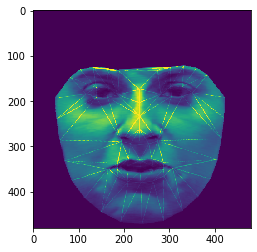

In [15]:
plt.imshow(images[257].getNeutralisedImage())

In [16]:
images[0].getName()

'..\\Data\\CK+\\cohn-kanade-images\\S005\\001\\S005_001_00000001.png'

In [17]:
import os
from PIL import Image

with tqdm(total=len(images), desc="Saving Neutralized emotions") as pbar:

    for image in images:

        path = "All_Images_Neutralised" + image.getName().split("Data")[-1]
        directory = "\\".join(path.split("\\")[:-1])

        if not os.path.exists(directory):
            os.makedirs(directory)

        try:
            im = Image.fromarray(image.getNeutralisedImage())
            im.save(path)
            pbar.update(1)
        except:
            
            pbar.update(1)
            continue

Saving Neutralized emotions: 100%|███████████████████████████████████████████████| 10708/10708 [03:47<00:00, 47.03it/s]


In [18]:
neutralized_image_files = glob.glob('All_Images_Neutralised\\CK+\\cohn-kanade-images/**/*.png', recursive=True)
len(neutralized_image_files)

10698

In [19]:
neutralized_image_files[1].split('\\')[3]

'S005'

In [20]:
def preprocess_neutralized(f,required_size=(160, 160)):
    ''' function to detect face, crop the image and resize it '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    
    image = Image.fromarray(gray)
    image = image.resize(required_size)
    image = image.convert('RGB')
    face_array = np.asarray(image)
    return face_array

In [21]:
faces_ck = list()
labels_ck  = list()
tmp_lab_prev = ''
tmp_lab = ''
for i in tqdm(range(len(neutralized_image_files)),desc = "Pre-processing neutralized images for FaceNet"):
    i_im = neutralized_image_files[i]
    
    tmp_lab = i_im.split('\\')[3]
    '''if(tmp_lab != tmp_lab_prev):
        print('Started pre-processing with subject:'+ tmp_lab)
    '''
    face = preprocess_neutralized(i_im)
    
     
    labels_ck.append(tmp_lab)
    
    # store
    faces_ck.append(face)
    tmp_lab_prev = tmp_lab

Pre-processing neutralized images for FaceNet: 100%|████████████████████████████| 10698/10698 [00:44<00:00, 240.32it/s]


In [22]:
ck_image_files[1].split('\\')[4]

'S005'

In [23]:
face_det = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
face_det2 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt2.xml")
face_det3 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt.xml")
face_det4 = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_frontalface_alt_tree.xml")

def preprocess_original(f,required_size=(160, 160)):
    ''' function to detect face, crop the image and resize it '''
    frame = cv2.imread(f) #Open image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #Convert image to grayscale
    face = face_det.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face2 = face_det2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face3 = face_det3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
    face4 = face_det4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

    
    #Go over detected faces, stop at first detected face, return empty if no face.
    if len(face) == 1:
        facefeatures = face
    elif len(face2) == 1:
        facefeatures = face2
    elif len(face3) == 1:
        facefeatures = face3
    elif len(face4) == 1:
        facefeatures = face4
    else:
        facefeatures = ""
    for (x, y, w, h) in facefeatures:
        gray = gray[y:y+h, x:x+w] #Cut the frame to size
        
    
        image = Image.fromarray(gray)
        image = image.resize(required_size)
        image = image.convert('RGB')
        face_array = np.asarray(image)
    return face_array

In [24]:
tmp_lab_prev = ''
tmp_lab = ''
for i in tqdm(range(len(ck_image_files)),desc = "Pre-processing original images for FaceNet"):
    i_im = ck_image_files[i]
    tmp_lab = i_im.split('\\')[4]
    '''
    if(tmp_lab != tmp_lab_prev):
        print('Started pre-processing with subject:'+ tmp_lab)
    '''
    face = preprocess_original(i_im)
    
     
    labels_ck.append(tmp_lab)
    
    # store
    faces_ck.append(face)
    tmp_lab_prev = tmp_lab

Pre-processing original images for FaceNet: 100%|████████████████████████████████| 10708/10708 [31:03<00:00,  5.75it/s]


In [25]:
X_full_ck = np.asarray(faces_ck)
l_full_ck = np.asarray(labels_ck)

In [26]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X_full_ck, l_full_ck, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17124, 160, 160, 3), (4282, 160, 160, 3), (17124,), (4282,))

In [27]:
# save arrays to one file in compressed format
np.savez_compressed('ck+dataset-combined.npz', X_train, y_train, X_test, y_test)

In [28]:
# load the face dataset
data = np.load('ck+dataset-combined.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (17124, 160, 160, 3) (17124,) (4282, 160, 160, 3) (4282,)


# Load pre-trained FaceNET model

In [29]:


model = load_model('..\\Data\\Model\\model\\facenet_keras.h5')

print(model.inputs)
print(model.outputs)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\anan2\Anaconda3\envs\test\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Merge:0' shape=(?, 128) dtype=float32>]



# Use FaceNet to generate embeddings for each image

In [30]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [31]:
# convert each face in the train set to an embedding
newTrainX = list()
for i in tqdm(range(trainX.shape[0]),desc = "Converting images in training set to embeddings using FaceNet"):
    face_pixels = trainX[i]
    embedding = get_embedding(model, face_pixels)
    '''if((i+1)% 100 == 0):
        print("Processed " + str(i+1) + " faces")
        '''
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

Converting images in training set to embeddings using FaceNet: 100%|█████████████| 17124/17124 [22:22<00:00, 12.75it/s]


(17124, 128)


In [32]:
# convert each face in the test set to an embedding
newTestX = list()
for i in tqdm(range(testX.shape[0]),desc = "Converting images in test set to embeddings using FaceNet"):
    face_pixels = testX[i]
    embedding = get_embedding(model, face_pixels)
    '''if((i+1)% 100 == 0):
        print("Processed " + str(i+1) + " faces")
    '''
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

Converting images in test set to embeddings using FaceNet: 100%|███████████████████| 4282/4282 [05:28<00:00, 13.02it/s]


(4282, 128)


In [33]:
# save arrays to one file in compressed format
np.savez_compressed('ck+-faces-embeddings-combined.npz', newTrainX, trainy, newTestX, testy)


# Train an SVM to do the recognition

In [2]:
# load necessary libraries
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot



In [3]:
# load faces
data = load('ck+dataset-combined.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('ck+-faces-embeddings-combined.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model_SVM = SVC(gamma=2, C=1, probability=True) #SVM with RBF Kernel
model_SVM.fit(trainX, trainy)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf', max_iter=-1,
    probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

## Performance evaluation


In [4]:
# prediction vector for the test set
yhat_accuracy = model_SVM.score(testX, testy)
print("Accuracy on test set = "+str(yhat_accuracy*100) + " %")

Accuracy on test set = 100.0 %


In [5]:
y_pred_shape_free = model_SVM.predict(testX)
c_mat_val = confusion_matrix(testy, y_pred_shape_free)
c_mat_val

array([[ 2,  0,  0, ...,  0,  0,  0],
       [ 0, 34,  0, ...,  0,  0,  0],
       [ 0,  0, 45, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 59,  0,  0],
       [ 0,  0,  0, ...,  0,  3,  0],
       [ 0,  0,  0, ...,  0,  0, 30]], dtype=int64)

In [6]:
print(classification_report(testy, y_pred_shape_free))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        45
           3       1.00      1.00      1.00        41
           4       1.00      1.00      1.00        75
           5       1.00      1.00      1.00        35
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00        45
           9       1.00      1.00      1.00        47
          10       1.00      1.00      1.00        30
          11       1.00      1.00      1.00        67
          12       1.00      1.00      1.00        40
          13       1.00      1.00      1.00        46
          14       1.00      1.00      1.00        40
          15       1.00      1.00      1.00        35
          16       1.00      1.00      1.00        40
          17       1.00    

## Run model on every test set example 

Predicted: S052 (70.678 %)
Expected: S052
Black Pixel count:12


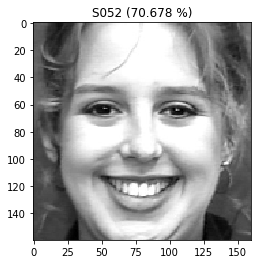

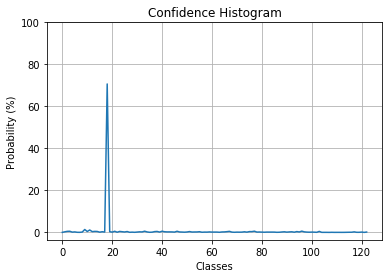

Predicted: S052 (75.679 %)
Expected: S052
Black Pixel count:24


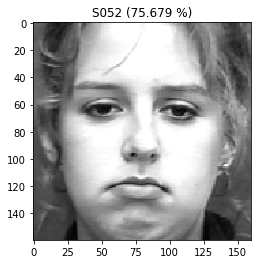

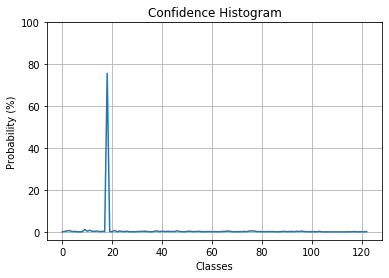

Predicted: S052 (78.883 %)
Expected: S052
Black Pixel count:39


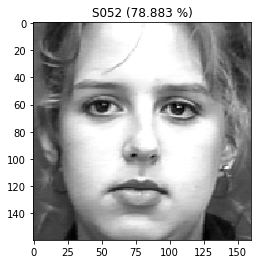

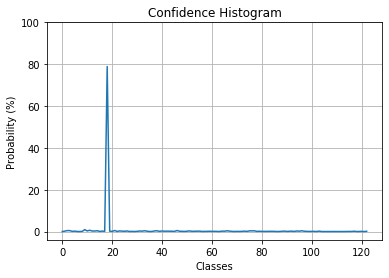

Predicted: S052 (68.953 %)
Expected: S052
Black Pixel count:24


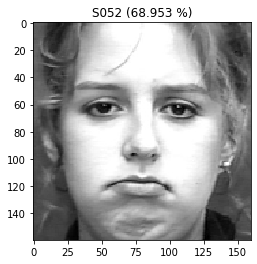

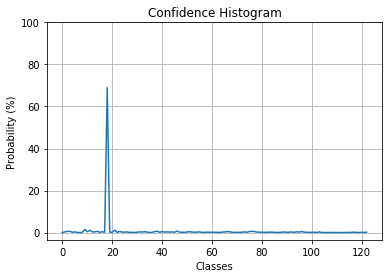

Predicted: S052 (67.193 %)
Expected: S052
Black Pixel count:41187


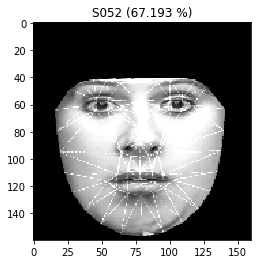

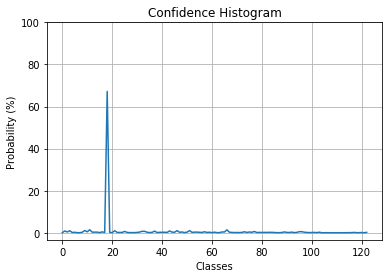

Predicted: S052 (83.760 %)
Expected: S052
Black Pixel count:41280


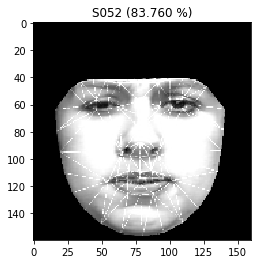

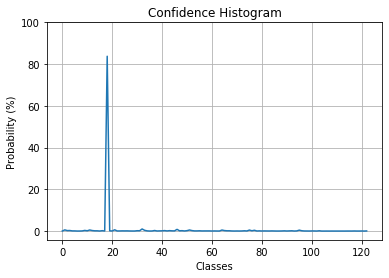

Predicted: S052 (79.766 %)
Expected: S052
Black Pixel count:9


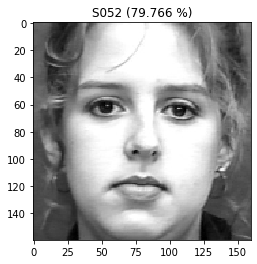

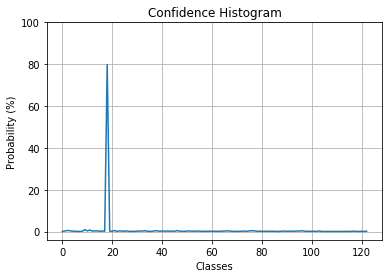

Predicted: S052 (69.201 %)
Expected: S052
Black Pixel count:41295


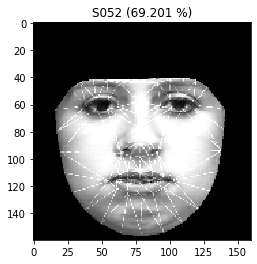

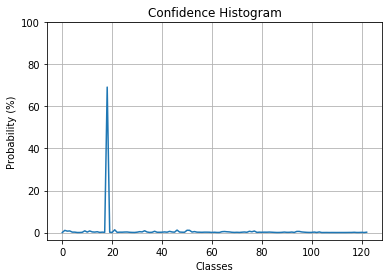

Predicted: S052 (69.351 %)
Expected: S052
Black Pixel count:41325


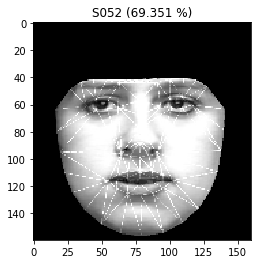

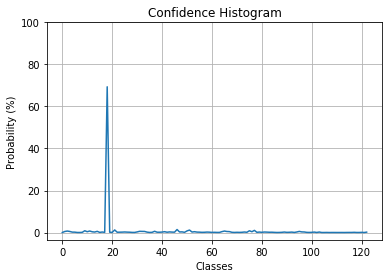

Predicted: S052 (72.712 %)
Expected: S052
Black Pixel count:30


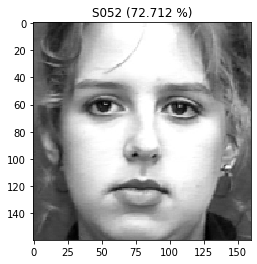

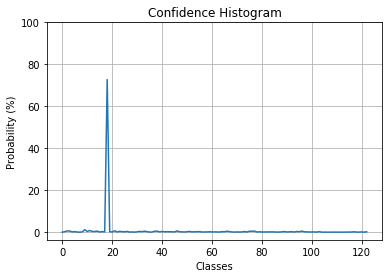

Predicted: S052 (66.895 %)
Expected: S052
Black Pixel count:30


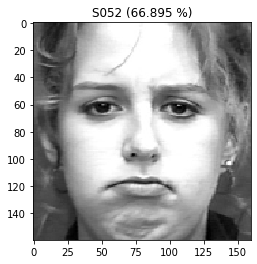

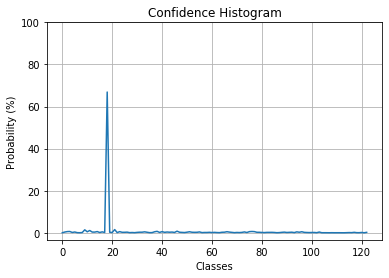

Predicted: S052 (73.029 %)
Expected: S052
Black Pixel count:36


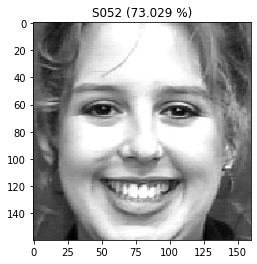

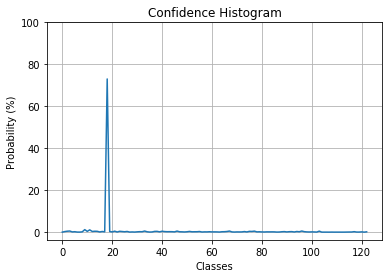

Predicted: S052 (69.539 %)
Expected: S052
Black Pixel count:41244


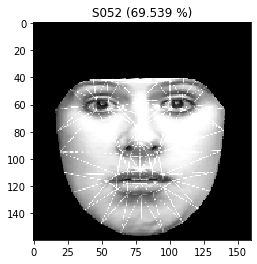

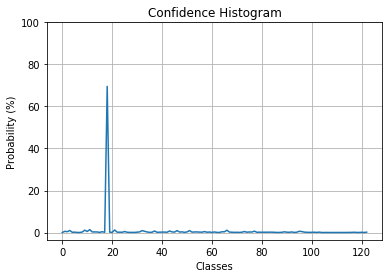

Predicted: S052 (71.573 %)
Expected: S052
Black Pixel count:41349


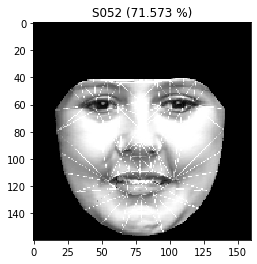

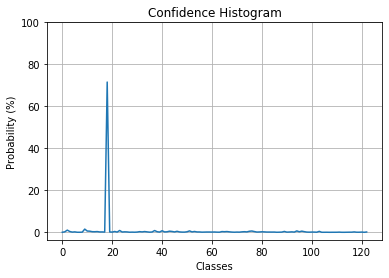

Predicted: S052 (53.760 %)
Expected: S052
Black Pixel count:41508


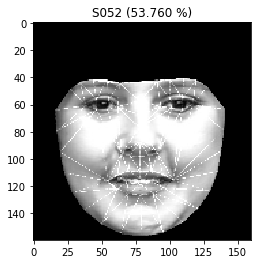

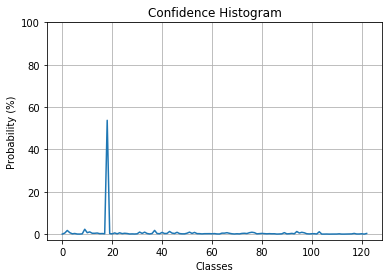

Predicted: S052 (57.657 %)
Expected: S052
Black Pixel count:6


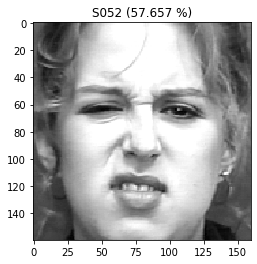

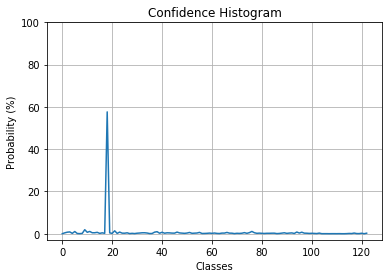

Predicted: S052 (73.454 %)
Expected: S052
Black Pixel count:12


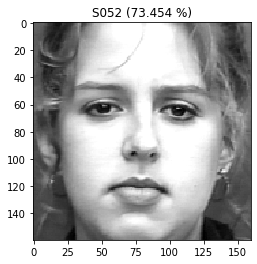

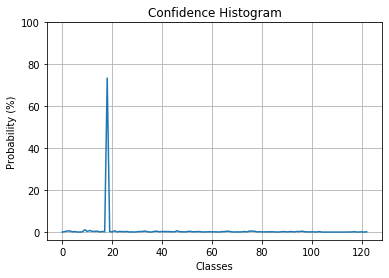

Predicted: S052 (69.821 %)
Expected: S052
Black Pixel count:33


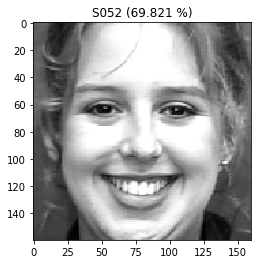

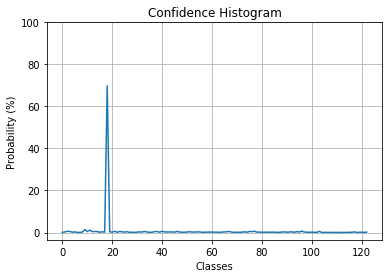

Predicted: S052 (71.864 %)
Expected: S052
Black Pixel count:41379


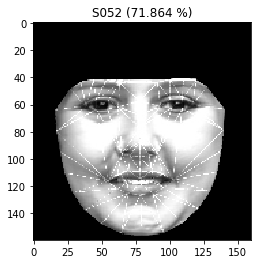

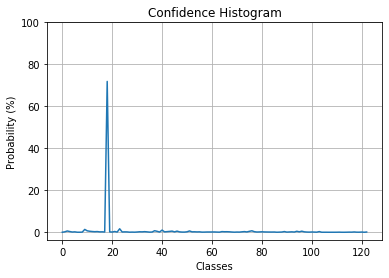

Predicted: S052 (69.091 %)
Expected: S052
Black Pixel count:27


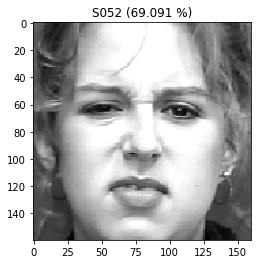

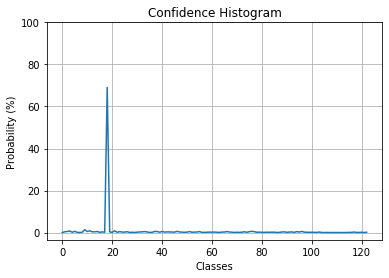

Predicted: S052 (64.482 %)
Expected: S052
Black Pixel count:3


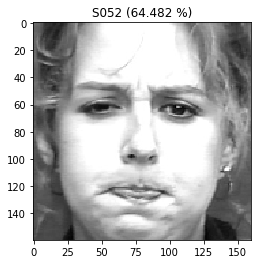

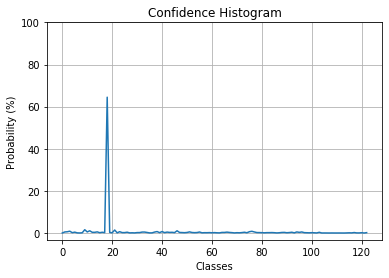

Predicted: S052 (76.400 %)
Expected: S052
Black Pixel count:41379


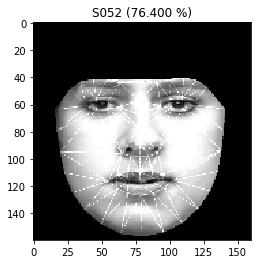

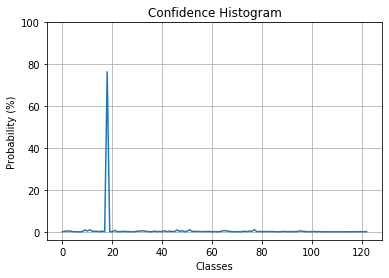

Predicted: S052 (62.703 %)
Expected: S052
Black Pixel count:41202


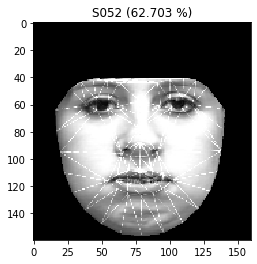

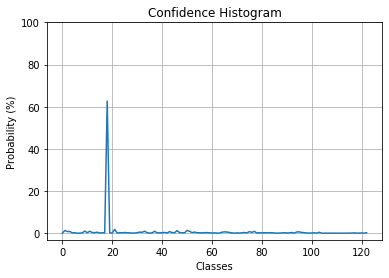

Predicted: S052 (64.285 %)
Expected: S052
Black Pixel count:41205


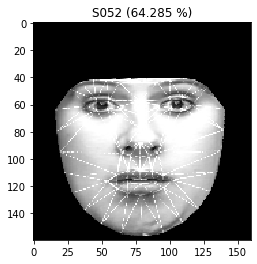

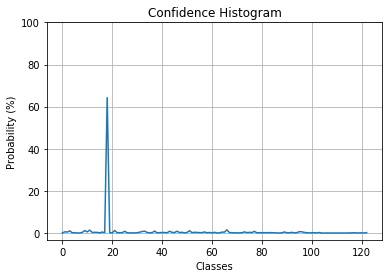

Predicted: S052 (50.589 %)
Expected: S052
Black Pixel count:41214


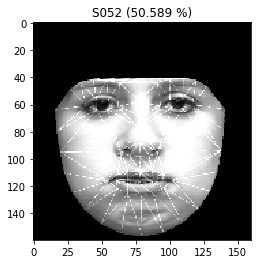

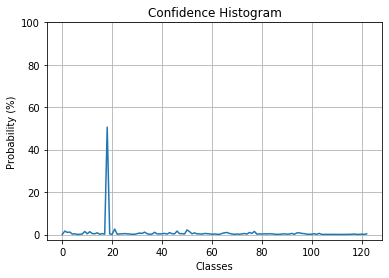

Predicted: S052 (66.904 %)
Expected: S052
Black Pixel count:30


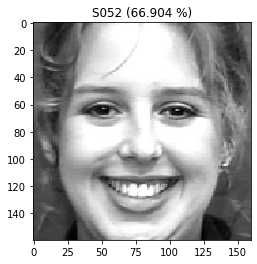

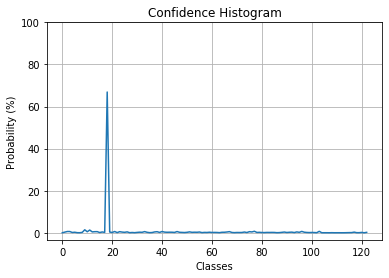

Predicted: S052 (81.530 %)
Expected: S052
Black Pixel count:41355


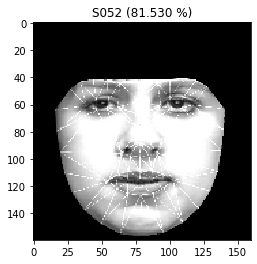

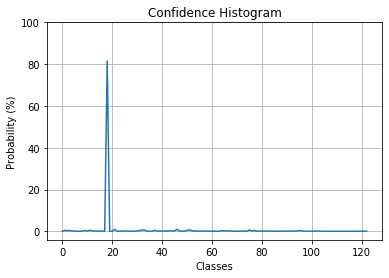

Predicted: S052 (69.116 %)
Expected: S052
Black Pixel count:27


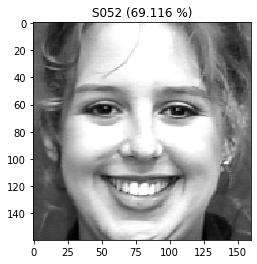

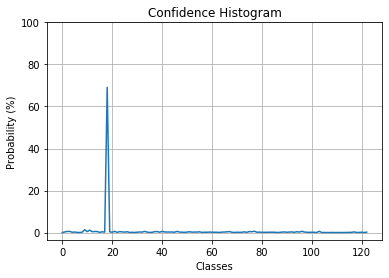

Predicted: S052 (57.885 %)
Expected: S052
Black Pixel count:41169


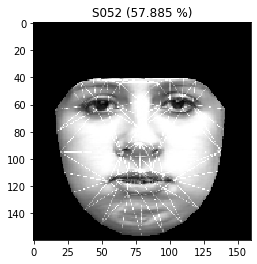

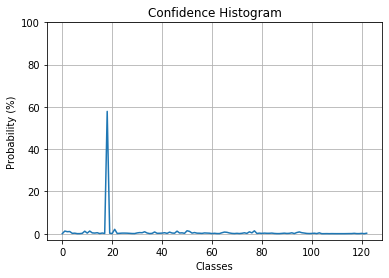

Predicted: S052 (74.681 %)
Expected: S052
Black Pixel count:41280


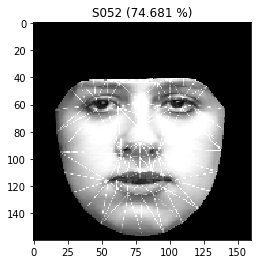

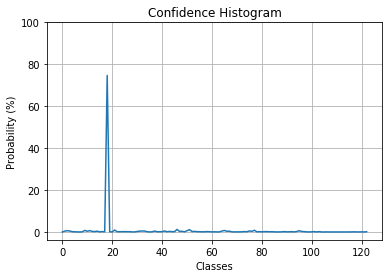

Predicted: S052 (81.809 %)
Expected: S052
Black Pixel count:41367


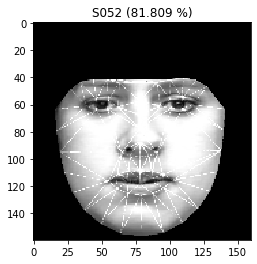

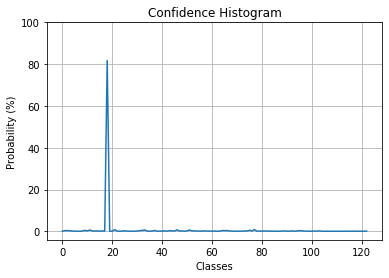

Predicted: S052 (76.525 %)
Expected: S052
Black Pixel count:3


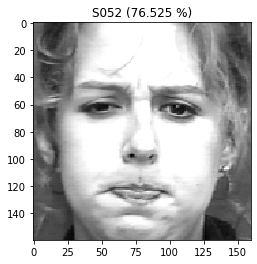

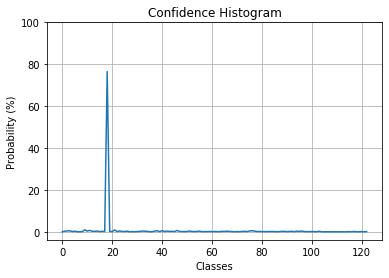

Predicted: S052 (63.765 %)
Expected: S052
Black Pixel count:3


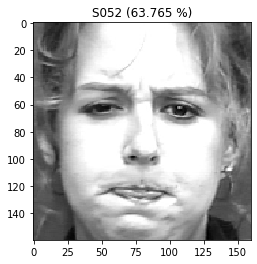

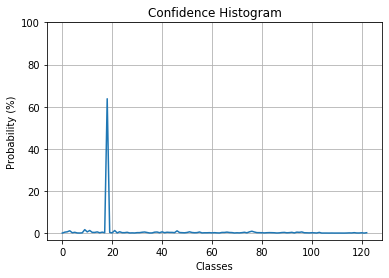

Predicted: S052 (76.891 %)
Expected: S052
Black Pixel count:41376


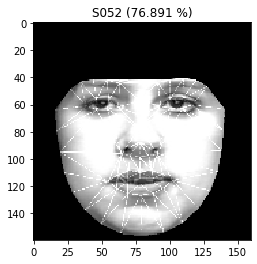

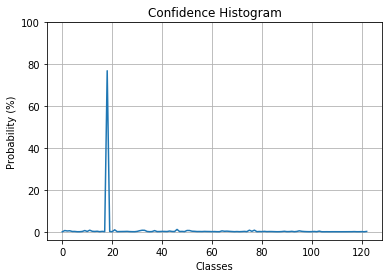

Predicted: S052 (87.718 %)
Expected: S052
Black Pixel count:41373


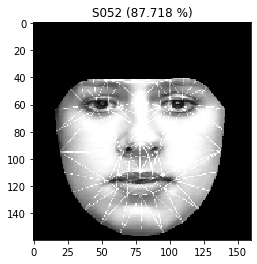

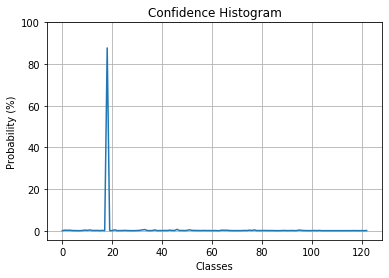

Predicted: S052 (58.387 %)
Expected: S052
Black Pixel count:15


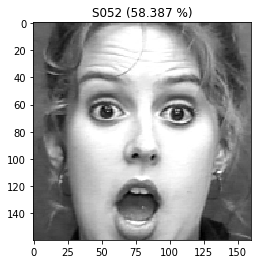

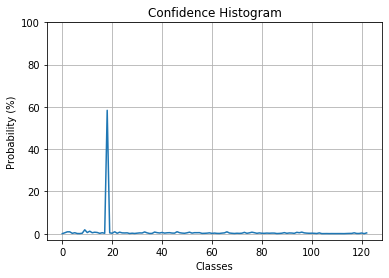

Predicted: S052 (58.988 %)
Expected: S052
Black Pixel count:33


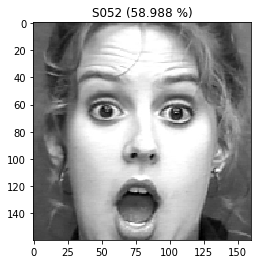

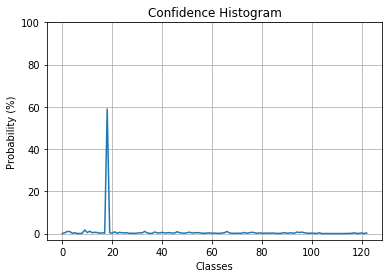

Predicted: S052 (66.842 %)
Expected: S052
Black Pixel count:27


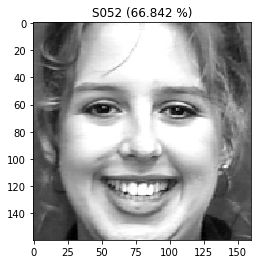

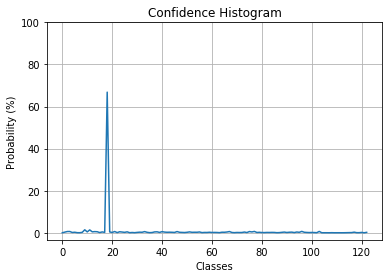

Predicted: S052 (64.220 %)
Expected: S052
Black Pixel count:15


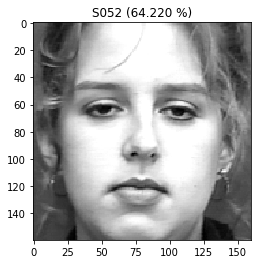

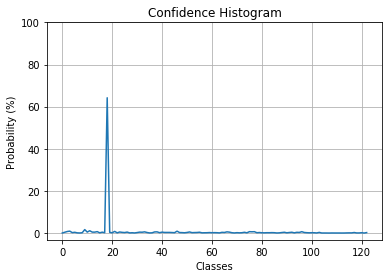

Predicted: S052 (69.662 %)
Expected: S052
Black Pixel count:54


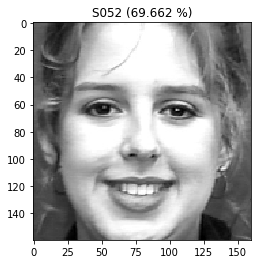

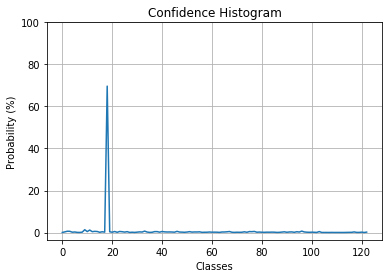

Predicted: S052 (62.185 %)
Expected: S052
Black Pixel count:41223


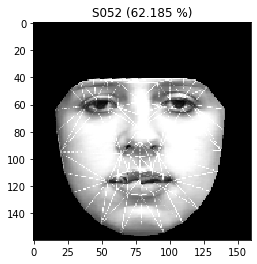

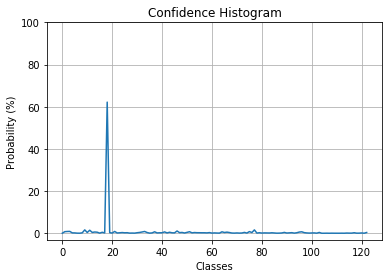

In [7]:
confidences_orig = list()
confidences_neutr = list()
confidences_t = list()
for ind in range(testX.shape[0]):
    # test model on a random example from the test dataset
    selection = ind
    
    random_face_pixels = testX_faces[selection]
    random_face_emb = testX[selection]
    random_face_class = testy[selection]
    random_face_name = out_encoder.inverse_transform([random_face_class])
    # prediction for the face
    samples = expand_dims(random_face_emb, axis=0)
    yhat_class = model_SVM.predict(samples)
    
    yhat_prob = model_SVM.predict_proba(samples)
    
    black_pixel_count = np.count_nonzero(random_face_pixels==0)
    
    
        
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    confidences_t.append(class_probability)
    if(black_pixel_count > 30000):
        confidences_neutr.append(class_probability)
    else:
        confidences_orig.append(class_probability)
    
    
    predict_names = out_encoder.inverse_transform(yhat_class)
    if(predict_names[0] == 'S052'):
        print('Predicted: %s (%.3f %%)' % (predict_names[0], class_probability))
        print('Expected: %s' % random_face_name[0])
        print('Black Pixel count:' + str(np.count_nonzero(random_face_pixels==0)))
        # plot for fun
        pyplot.imshow(random_face_pixels)
        title = '%s (%.3f %%)' % (predict_names[0], class_probability)
        pyplot.title(title)


        pyplot.show()
        pyplot.plot(yhat_prob.flatten() * 100)
        x1,x2,y1,y2 = plt.axis()

        plt.axis((x1,x2,y1,100))
        pyplot.ylabel("Probability (%)")
        pyplot.xlabel("Classes")
        pyplot.title("Confidence Histogram")
        pyplot.grid()

        pyplot.show()

### This cell contains list of publishable faces

In [8]:
#or predict_names[0] == 'S052' or predict_names[0] == 'S055' or predict_names[0] == 'S074'or predict_names[0] == 'S106' or predict_names[0] == 'S111' or predict_names[0] == 'S113' or predict_names[0] == 'S121' or predict_names[0] == 'S124' or predict_names[0] == 'S125' or predict_names[0] == 'S130' or predict_names[0] == 'S132'):
       

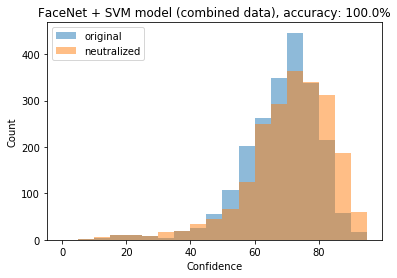

In [14]:
plt.hist(confidences_orig, density=False, alpha=0.5, bins=range(0,100,5), label='original')
plt.hist(confidences_neutr, density=False, alpha=0.5, bins=range(0,100,5), label='neutralized')
plt.ylabel('Count')
plt.xlabel('Confidence')
plt.title('FaceNet + SVM model (combined data), accuracy: {}%'.format( yhat_accuracy * 100))
#plt.savefig('FaceNet_SVM_Combined.png')
plt.legend()

In [10]:
selection = 1
    
random_face_pixels = testX_faces[selection]

In [22]:
np.count_nonzero(random_face_pixels==0)


41256